# Regression

## Objectives

*   Fit and evaluate a regression model to predict tenure levels for a prospect that will likely churn


## Inputs

* outputs/datasets/collection/bank-customer-churn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tenure
* labels map
* Feature Importance Plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer'

---

# Load Data

In [5]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/bank-customer-churn.csv")
      .query("Exited == 1")  # subset churned customer
      .drop(labels=['CustomerId', 'RowNumber', 'Surname','Exited'], axis=1)
      # variables we will not need for this project
      # we will not need Exited since it has only 1
      )

cat_vars = ['Geography','Gender','HasCrCard','IsActiveMember','NumOfProducts']
df[cat_vars] = df[cat_vars].astype(object)

print(df.shape)
df.head(3)


(2037, 10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71


# MP Pipeline: Regressor

## Create ML pipeline

In [7]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor



def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("boxcox", vt.BoxCoxTransformer(variables=['Age'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['Age','CreditScore'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['Gender','Geography'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for hyperparameter optimisation

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': abs(min(scores)), # Absolute numbers to pick correct regressor
                'max_score': abs(max(scores)),
                'mean_score': abs(np.mean(scores)),
                'std_score': abs(np.std(scores)),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Tenure'], axis=1),
    df['Tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1629, 9) (1629,) 
* Test set: (408, 9) (408,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [11]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [12]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be remove

Check results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
1,DecisionTreeRegressor,1.1895,0.986395,0.806342,0.146208
6,XGBRegressor,0.326052,0.22533,0.143937,0.066462
3,ExtraTreesRegressor,0.210262,0.128283,0.053853,0.06198
5,GradientBoostingRegressor,0.120401,0.067349,0.041627,0.028211
2,RandomForestRegressor,0.16992,0.064872,0.008572,0.057763
4,AdaBoostRegressor,0.01481,0.006595,0.00145,0.004811
0,LinearRegression,0.025913,0.002862,0.00832,0.012205


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [14]:
models_search = {
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may consider more hyperparameters and spend more time in this step

params_search = {
    "DecisionTreeRegressor": {
           'model__max_depth': [3, 5, 7, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
    }
}

Extensive GridSearch CV

In [15]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Check results

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split
27,DecisionTreeRegressor,0.523648,0.406599,0.324624,0.075386,10,1,2
28,DecisionTreeRegressor,0.490011,0.389475,0.324633,0.060332,10,1,5
30,DecisionTreeRegressor,0.527974,0.382685,0.288781,0.086567,10,2,2
31,DecisionTreeRegressor,0.491031,0.36512,0.253863,0.084309,10,2,5
32,DecisionTreeRegressor,0.457486,0.339979,0.270652,0.068604,10,2,10
29,DecisionTreeRegressor,0.48835,0.339432,0.242031,0.083261,10,1,10
34,DecisionTreeRegressor,0.466501,0.301015,0.190731,0.097352,10,4,5
33,DecisionTreeRegressor,0.466501,0.301015,0.190731,0.097352,10,4,2
35,DecisionTreeRegressor,0.433606,0.285957,0.184487,0.091754,10,4,10
18,DecisionTreeRegressor,0.312807,0.206729,0.086705,0.079599,7,1,2


Check the best model

In [17]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'DecisionTreeRegressor'

Parameters for best model

In [18]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 3,
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 10}

Define the best regressor, based on search

In [19]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('boxcox', BoxCoxTransformer(variables=['Age'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['CreditScore', 'Geography',
                                                     'Gender', 'Age', 'Balance',
                                                     'EstimatedSalary'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['Balance', 'EstimatedSalary', 'Age', 'CreditScore']


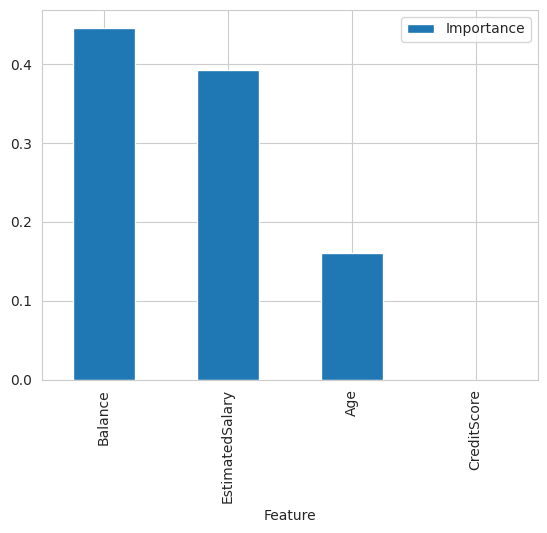

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.027
Mean Absolute Error: 2.504
Mean Squared Error: 8.499
Root Mean Squared Error: 2.915


* Test Set
R2 Score: -0.019
Mean Absolute Error: 2.464
Mean Squared Error: 8.299
Root Mean Squared Error: 2.881




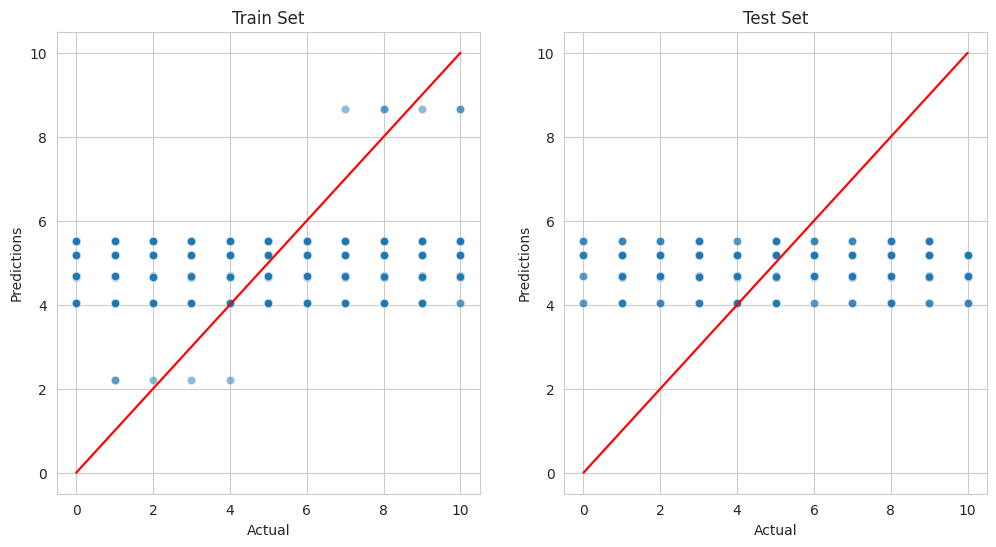

In [22]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Regressor with PCA

Let's explore potential values for PCA n_components.

In [ ]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['Tenure'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

Apply PCA separately to the scaled data

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 9


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


In [ ]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [ ]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Gender', 'Geography'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


## Grid Search CV – Sklearn

In [ ]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

### Use standard hyperparameters to find the most suitable model.

In [ ]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optimisation search 

In [ ]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [ ]:
models_search = {
    "DecisionTreeRegressor":DecisionTreeRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "DecisionTreeRegressor":{
          'model__max_depth': [3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5]
    }
}

Extensive GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model

In [ ]:
grid_search_pipelines[best_model].best_params_

Define the best regressor

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

## Evaluate Regressor on Train and Tests Sets

In [ ]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

# Convert Regression to Classification

### Convert numerical target to bins, and check if it is balanced

* The classes represent the following ranges: 
{'Tenure': [-inf, 5.0, inf]} 



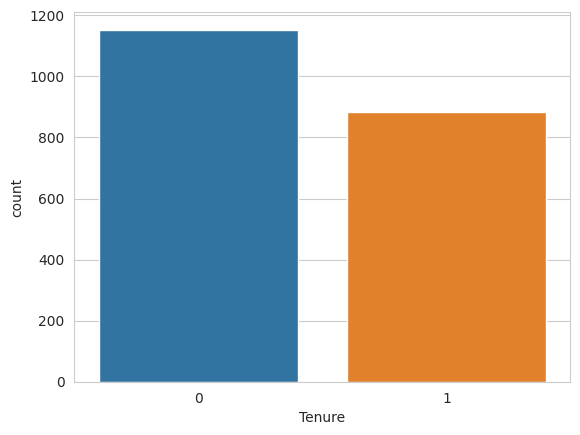

In [42]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=2, variables=['Tenure'])  # we will try q as 2, and 3
df_clf = disc.fit_transform(df)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='Tenure')
plt.show()

In [43]:
df_clf.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,0,0.00,1,1,1,101348.88
2,502,France,Female,42,1,159660.80,3,1,0,113931.57
5,645,Spain,Male,44,1,113755.78,2,1,0,149756.71


## Rewrite ML Pipeline for Modelling

In [44]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("boxcox", vt.BoxCoxTransformer(variables=['Age'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['Age','CreditScore'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['Gender','Geography'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


## Load algorithms for classification

In [45]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## Split Train Test Sets

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Tenure'], axis=1),
    df_clf['Tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1629, 9) (1629,) 
* Test set: (408, 9) (408,)


## Grid Seach CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [47]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [48]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be remove


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [49]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,AdaBoostClassifier,0.766304,0.813801,0.843243,0.028934
3,GradientBoostingClassifier,0.724324,0.784671,0.837838,0.043269
4,ExtraTreesClassifier,0.627027,0.680752,0.740541,0.040899
2,RandomForestClassifier,0.621622,0.67641,0.713514,0.030035
0,XGBClassifier,0.562162,0.622291,0.67027,0.039505
1,DecisionTreeClassifier,0.486486,0.563884,0.621622,0.053662


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [50]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "AdaBoostClassifier": {
    'model__n_estimators': [10, 50, 100, 500, 1000, 5000]
    }
}


Extensive GridSearch CV

In [51]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)



Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Check results

In [52]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__n_estimators
0,AdaBoostClassifier,0.805405,0.861504,0.891304,0.029998,10
1,AdaBoostClassifier,0.766304,0.813801,0.843243,0.028934,50
2,AdaBoostClassifier,0.735135,0.76839,0.821622,0.03033,100
3,AdaBoostClassifier,0.654054,0.690464,0.740541,0.030581,500
4,AdaBoostClassifier,0.630435,0.663384,0.718919,0.031444,1000
5,AdaBoostClassifier,0.572973,0.619025,0.681081,0.039738,5000



Check the best model

In [53]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Parameters for best model
* We are saving this content for later

In [54]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__n_estimators': 10}

Define the best clf pipeline

In [55]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('boxcox', BoxCoxTransformer(variables=['Age'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['CreditScore', 'Geography',
                                                     'Gender', 'Age', 'Balance',
                                                     'EstimatedSalary'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel

## Assess feature importance

We can assess feature importance for this model with `.feature_importances_`

* These are the 4 most important features in descending order. The model was trained on them: 
['EstimatedSalary', 'Balance', 'Age', 'CreditScore']


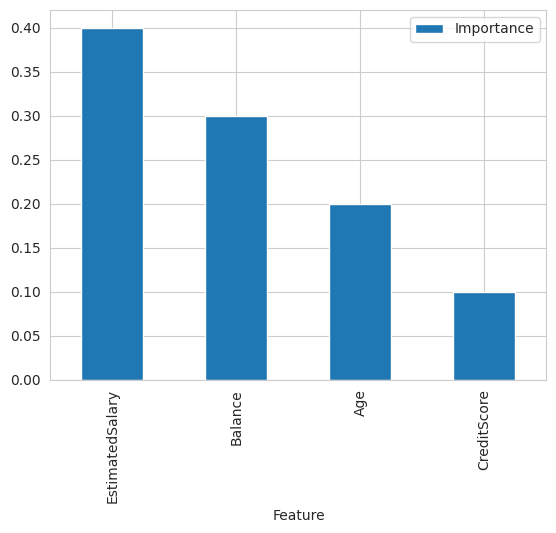

In [56]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

Custom Function

In [57]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


List that relates the classes and tenure interval

In [58]:
disc.binner_dict_['Tenure']

[-inf, 5.0, inf]

We can create manually

In [59]:
label_map = ['<5.0','+5.0']
label_map

['<5.0', '+5.0']

In [60]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                Actual <5.0 Actual +5.0
Prediction <5.0         788         529
Prediction +5.0         136         176


---  Classification Report  ---
              precision    recall  f1-score   support

        <5.0       0.60      0.85      0.70       924
        +5.0       0.56      0.25      0.35       705

    accuracy                           0.59      1629
   macro avg       0.58      0.55      0.52      1629
weighted avg       0.58      0.59      0.55      1629
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual <5.0 Actual +5.0
Prediction <5.0         178         143
Prediction +5.0          51          36


---  Classification Report  ---
              precision    recall  f1-score   support

        <5.0       0.55      0.78      0.65       229
        +5.0       0.41      0.20      0.27       179

    accuracy                           0.52       408
   macro avg       0.48      0.49      0.46      

# Which pipeline to choose?

We fitted 3 pipelines:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold (0.7 R2 score) for the train and test set.

The classifier was tuned on Recall for class 0 (tenure <4 months), since we are interested to detect prospects that may churn soon. 
* It has reasonable performance for class 0 (<4 months) and class 2 (+20 months)
* Class 1 (4 to 20 months) has weak performance.

In [62]:
pipeline_clf

Pipeline(steps=[('boxcox', BoxCoxTransformer(variables=['Age'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['CreditScore', 'Geography',
                                                     'Gender', 'Age', 'Balance',
                                                     'EstimatedSalary'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel

# Refit pipeline with best features

## Rewrite Pipeline

In [76]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("boxcox", vt.BoxCoxTransformer(variables=['Age'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['Age','CreditScore'])),
 
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),
        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base


## Split Train Test Set, only with best features

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Tenure'], axis=1),
    df_clf['Tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1629, 9) (1629,) 
* Test set: (408, 9) (408,)


Subset Best Features

In [66]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1629, 4) (1629,) 
* Test set: (408, 4) (408,)


,EstimatedSalary,Balance,Age,CreditScore
9770,72577.33,121197.64,49,520
1500,63606.22,81947.76,50,630
2499,131766.67,75150.34,37,614


## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [67]:
models_search

{'AdaBoostClassifier': AdaBoostClassifier(random_state=0)}

And the best parameters from the previous GridCV search

In [68]:
best_parameters

{'model__n_estimators': 10}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [70]:
params_search = {'AdaBoostClassifier':  {
      'model__n_estimators': [10]       # the value should be in []
}
}
params_search

{'AdaBoostClassifier': {'model__n_estimators': [10]}}

GridSearch CV

In [77]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Check results

In [78]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__n_estimators
0,AdaBoostClassifier,0.762162,0.852855,0.891304,0.046577,10


Check the best model

In [79]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Define the best clf pipeline

In [80]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('boxcox', BoxCoxTransformer(variables=['Age'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'CreditScore'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['EstimatedSalary',
                                                     'Balance', 'Age',
                                                     'CreditScore'])),
                ('feat_scaling', StandardScaler()),
                ('model', AdaBoostClassifier(n_estimators=10, random_state=0))])

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['EstimatedSalary', 'Balance', 'Age', 'CreditScore']


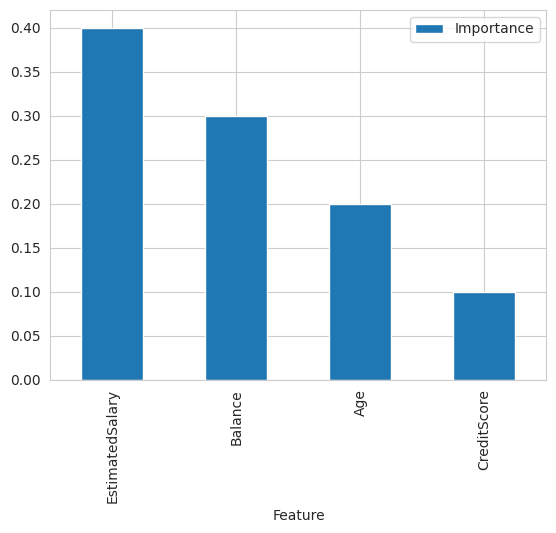

In [81]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

In [82]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                Actual <5.0 Actual +5.0
Prediction <5.0         788         529
Prediction +5.0         136         176


---  Classification Report  ---
              precision    recall  f1-score   support

        <5.0       0.60      0.85      0.70       924
        +5.0       0.56      0.25      0.35       705

    accuracy                           0.59      1629
   macro avg       0.58      0.55      0.52      1629
weighted avg       0.58      0.59      0.55      1629
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual <5.0 Actual +5.0
Prediction <5.0         178         143
Prediction +5.0          51          36


---  Classification Report  ---
              precision    recall  f1-score   support

        <5.0       0.55      0.78      0.65       229
        +5.0       0.41      0.20      0.27       179

    accuracy                           0.52       408
   macro avg       0.48      0.49      0.46      

# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [83]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_tenure/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [84]:
X_train.head()

,EstimatedSalary,Balance,Age,CreditScore
9770,72577.33,121197.64,49,520
1500,63606.22,81947.76,50,630
2499,131766.67,75150.34,37,614
8186,50560.45,0.00,39,606
7783,148330.97,0.00,43,437


In [85]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [86]:
y_train

9770    0
1500    0
2499    1
8186    0
7783    1
       ..
3957    0
5853    0
8030    0
2629    0
3240    0
Name: Tenure, Length: 1629, dtype: int64

In [87]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [88]:
X_test.head()

,EstimatedSalary,Balance,Age,CreditScore
4447,140136.10,109062.28,50,666
894,54359.02,125884.95,35,728
6479,149946.43,0.00,49,648
9750,92920.04,70754.18,51,708
9716,185599.34,115730.71,39,812


In [89]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [90]:
y_test

4447    1
894     1
6479    0
9750    1
9716    0
       ..
406     1
5972    1
5933    0
7152    1
1520    0
Name: Tenure, Length: 408, dtype: int64

In [91]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

ML pipeline for predicting tenure

In [92]:
pipeline_clf

Pipeline(steps=[('boxcox', BoxCoxTransformer(variables=['Age'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'CreditScore'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['EstimatedSalary',
                                                     'Balance', 'Age',
                                                     'CreditScore'])),
                ('feat_scaling', StandardScaler()),
                ('model', AdaBoostClassifier(n_estimators=10, random_state=0))])

In [93]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

['outputs/ml_pipeline/predict_tenure/v1/clf_pipeline.pkl']

## List  mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [94]:
label_map

['<5.0', '+5.0']

In [95]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

['outputs/ml_pipeline/predict_tenure/v1/label_map.pkl']

## Feature importance plot

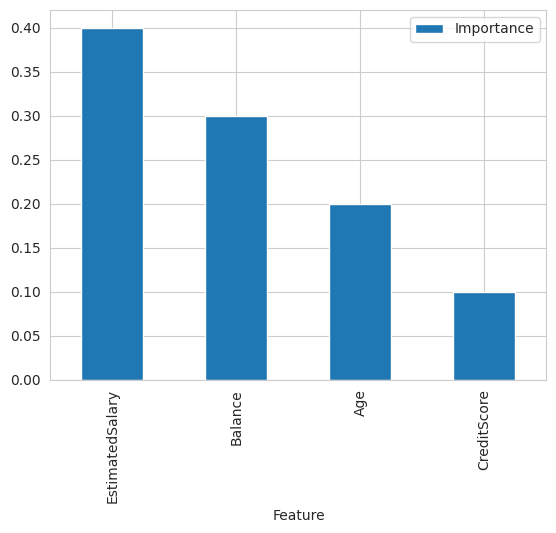

In [96]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

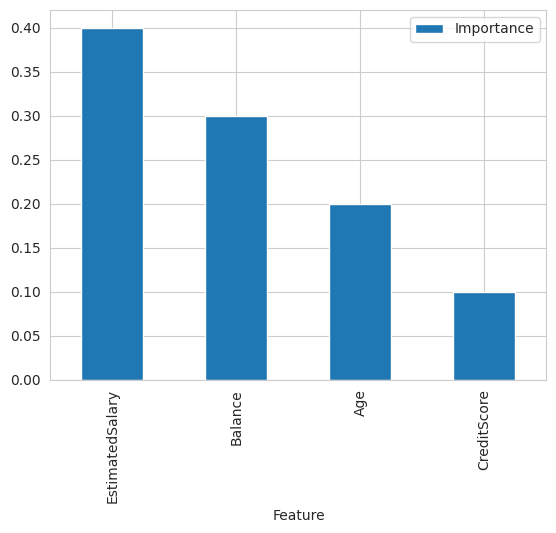

In [97]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job! Clear cell's outputs, push to the repo using git commands and move on to the next notebook

---